In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from NeuralNetwork.Network import Network
from NeuralNetwork.Layers.Input import Input
from NeuralNetwork.Layers.RNN import RNN
from NeuralNetwork.Layers.GRU import GRU
from NeuralNetwork.Layers.LSTM import LSTM
from NeuralNetwork.Losses.MSE import MSE
from NeuralNetwork.Activations.Tanh import Tanh
from NeuralNetwork.Metrics import Metric, Plot

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Предобработка данных

## Загрузка данных

In [5]:
df = pd.read_csv('Steel_industry_data.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(columns=['date'])
rows, columns = df.shape

## Описание данных

In [6]:
df.head()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
date                                                                   
2018-01-01 00:15:00       3.17                                  2.95   
2018-01-01 00:30:00       4.00                                  4.46   
2018-01-01 00:45:00       3.24                                  3.28   
2018-01-01 01:00:00       3.31                                  3.56   
2018-01-01 01:15:00       3.82                                  4.50   

                     Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
date                                                                   
2018-01-01 00:15:00                                   0.0        0.0   
2018-01-01 00:30:00                                   0.0        0.0   
2018-01-01 00:45:00                                   0.0        0.0   
2018-01-01 01:00:00                                   0.0        0.0   
2018-01-01 01:15:00                                   0.0        0.0   

                     Lagging_Current_Power_Factor  \
date                                                
2018-01-01 00:15:00                         73.21   
2018-01-01 00:30:00                         66.77   
2018-01-01 00:45:00                         70.28   
2018-01-01 01:00:00                         68.09   
2018-01-01 01:15:00                         64.72   

                     Leading_Current_Power_Factor   NSM WeekStatus  \
date                                                                 
2018-01-01 00:15:00                         100.0   900    Weekday   
2018-01-01 00:30:00                         100.0  1800    Weekday   
2018-01-01 00:45:00                         100.0  2700    Weekday   
2018-01-01 01:00:00                         100.0  3600    Weekday   
2018-01-01 01:15:00                         100.0  4500    Weekday   

                    Day_of_week   Load_Type  
date                                         
2018-01-01 00:15:00      Monday  Light_Load  
2018-01-01 00:30:00      Monday  Light_Load  
2018-01-01 00:45:00      Monday  Light_Load  
2018-01-01 01:00:00      Monday  Light_Load  
2018-01-01 01:15:00      Monday  Light_Load

In [7]:
df.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [8]:
df.dtypes

Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
dtype: object

In [9]:
object_columns = df.columns[(df.dtypes == object)]
numeric_columns = df.columns[(df.dtypes != object)]

In [10]:
for column in object_columns:
    print(f"{column}: ")
    print(df[column].unique())

WeekStatus: 
['Weekday' 'Weekend']
Day_of_week: 
['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Load_Type: 
['Light_Load' 'Medium_Load' 'Maximum_Load']


In [11]:
params = pd.DataFrame()
params.index = ['Количество', '% пропусков', 'Мощность', 'Мода', 'Частота']
for column in object_columns:
    params[column] = [len(df[column]), df[column].isna().sum() * 100 / len(df[column]), df[column].nunique(), df[column].mode().values[0], df[column].value_counts()[df[column].mode().values[0]]]

params = params.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:limegreen" if i!=1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:steelblue" if i<60 and i >= 30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:limegreen" if i<30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None)))
params

In [12]:
params = pd.DataFrame()
params.index = ['Количество', '% пропусков', 'Минимум', 'Среднее', 'Максимум', 'Стандартное отклонение', 'Мощность', 'Первый квартиль', 'Медиана', 'Третий квартиль', 'IQR']
for column in numeric_columns:
    params[column] = [len(df[column]), df[column].isna().sum() * 100 / len(df[column]), df[column].min(), df[column].mean(), df[column].max(), df[column].std(), df[column].nunique(), df[column].quantile(0.25), df[column].quantile(0.5), df[column].quantile(0.75), df[column].quantile(0.25) - df[column].quantile(0.75)]

params = params.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:limegreen" if i!=1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:steelblue" if i<60 and i >= 30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:limegreen" if i<30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None)))
params

## Распределения

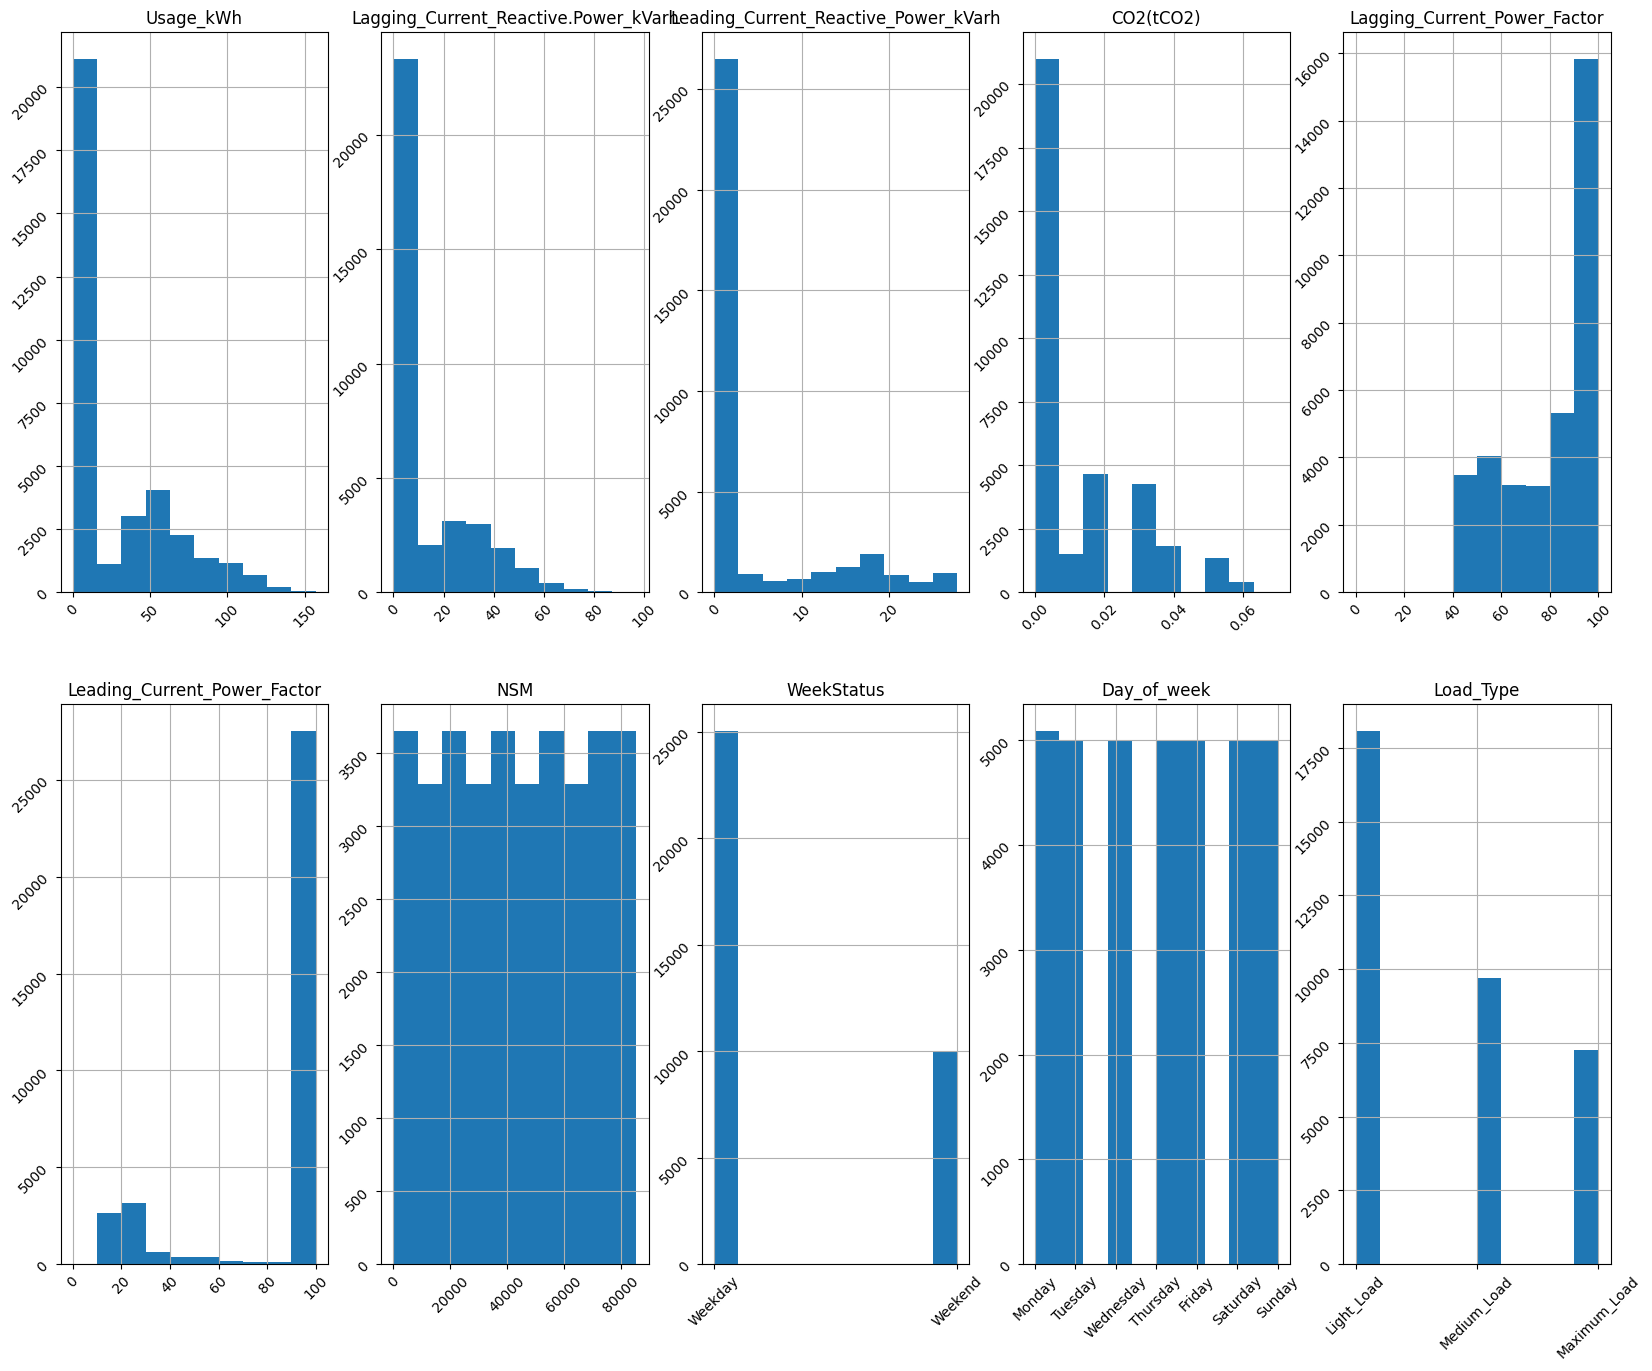

In [13]:
if columns % 5 == 0:
    f, ax = plt.subplots(int(columns // 5), 5, figsize=(20,int(columns // 5) * 8))
else:
    f, ax = plt.subplots(int(columns // 5) + 1, 5, figsize=(20,(int(columns // 5) + 1) * 8))

i = 0
j = 0
for column in df.columns:
    if j == 5:
        j = 0
        i += 1
    df[column].hist(ax=ax[i, j])
    ax[i, j].set_title(column)
    ax[i, j].tick_params(labelrotation=45)
    j += 1

## Временные ряды

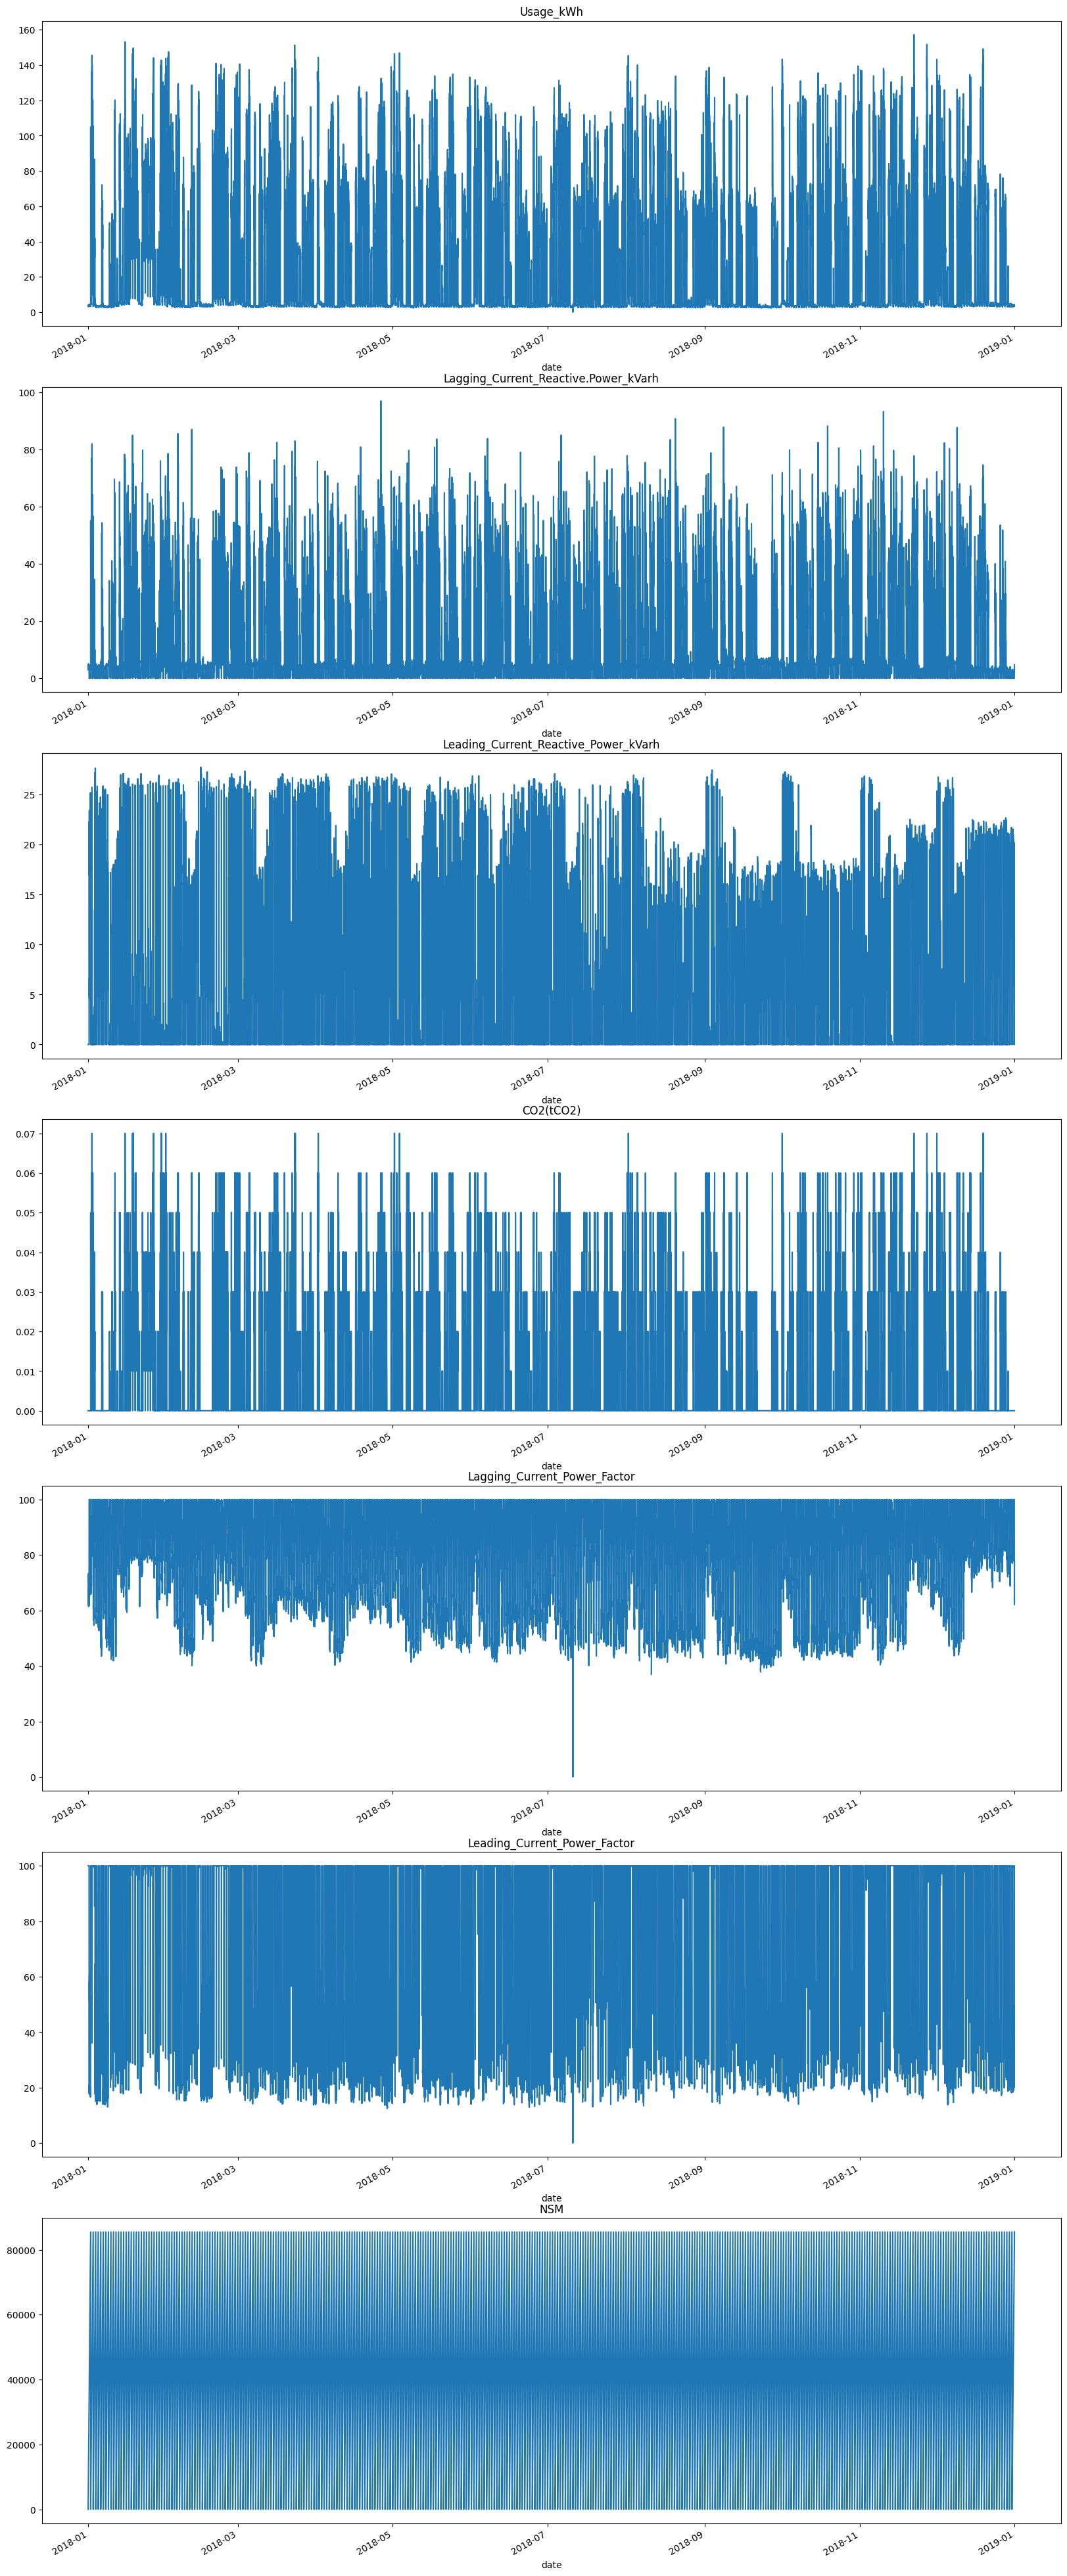

In [14]:
f, ax = plt.subplots(len(numeric_columns), 1, figsize=(20, len(numeric_columns) * 8))
i = 0
for column in numeric_columns:
    df[column].plot(ax=ax[i])
    ax[i].set_title(column)
    i+=1

## Обработка категориальных признаков

In [15]:
for column in object_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [16]:
df.head()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
date                                                                   
2018-01-01 00:15:00       3.17                                  2.95   
2018-01-01 00:30:00       4.00                                  4.46   
2018-01-01 00:45:00       3.24                                  3.28   
2018-01-01 01:00:00       3.31                                  3.56   
2018-01-01 01:15:00       3.82                                  4.50   

                     Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
date                                                                   
2018-01-01 00:15:00                                   0.0        0.0   
2018-01-01 00:30:00                                   0.0        0.0   
2018-01-01 00:45:00                                   0.0        0.0   
2018-01-01 01:00:00                                   0.0        0.0   
2018-01-01 01:15:00                                   0.0        0.0   

                     Lagging_Current_Power_Factor  \
date                                                
2018-01-01 00:15:00                         73.21   
2018-01-01 00:30:00                         66.77   
2018-01-01 00:45:00                         70.28   
2018-01-01 01:00:00                         68.09   
2018-01-01 01:15:00                         64.72   

                     Leading_Current_Power_Factor   NSM  WeekStatus  \
date                                                                  
2018-01-01 00:15:00                         100.0   900           0   
2018-01-01 00:30:00                         100.0  1800           0   
2018-01-01 00:45:00                         100.0  2700           0   
2018-01-01 01:00:00                         100.0  3600           0   
2018-01-01 01:15:00                         100.0  4500           0   

                     Day_of_week  Load_Type  
date                                         
2018-01-01 00:15:00            1          0  
2018-01-01 00:30:00            1          0  
2018-01-01 00:45:00            1          0  
2018-01-01 01:00:00            1          0  
2018-01-01 01:15:00            1          0

In [17]:
df.dtypes

Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                                int32
Day_of_week                               int32
Load_Type                                 int32
dtype: object

## Корреляции

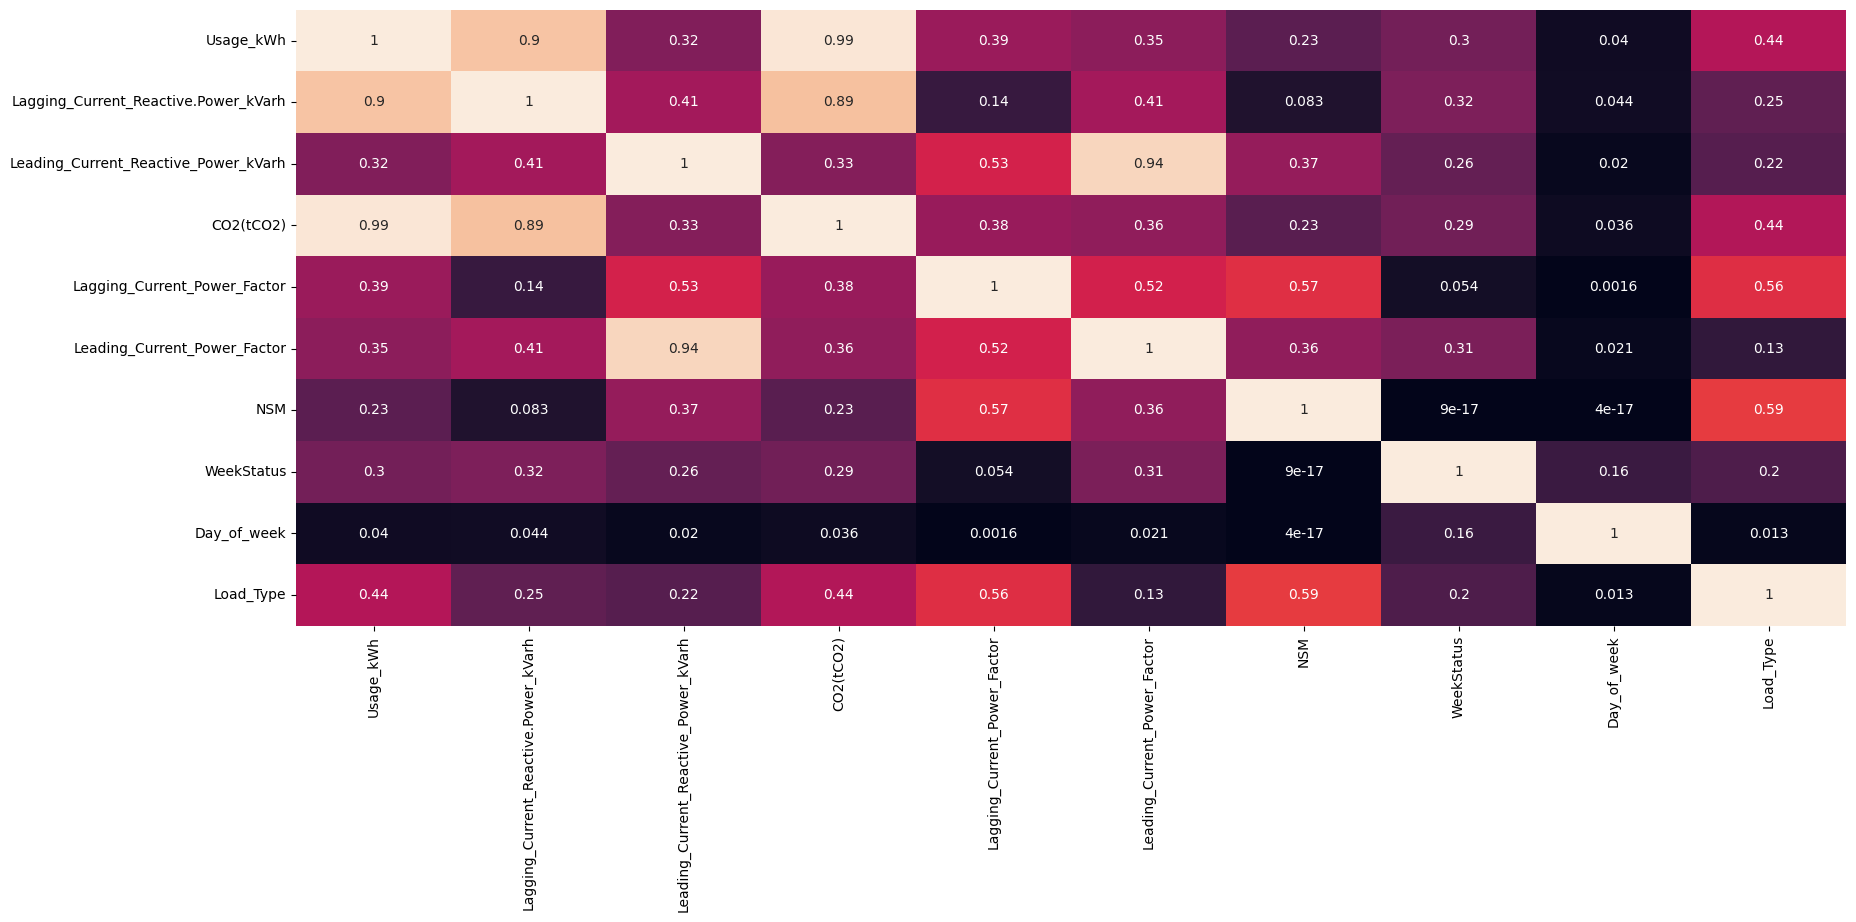

In [18]:
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(abs(df.corr()), annot=True, ax=ax, cbar=False)
plt.show()

## Важность признаков

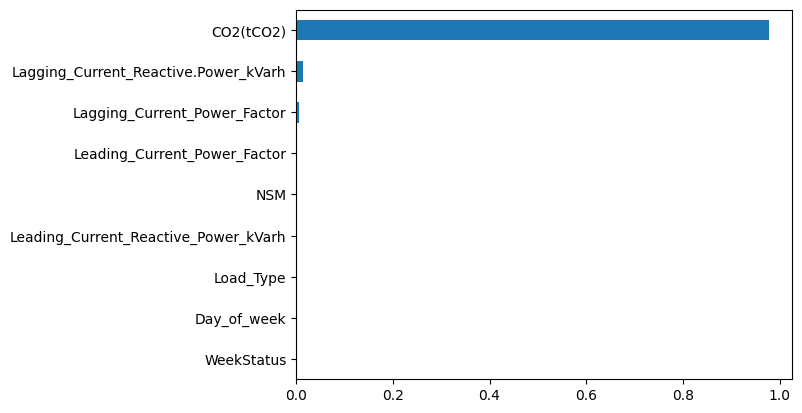

In [19]:
rfc = RandomForestRegressor()
rfc.fit(df.drop(columns=['Usage_kWh']), df['Usage_kWh'])

imp = pd.Series(rfc.feature_importances_, df.drop(columns=['Usage_kWh']).columns[0:len(df.drop(columns=['Usage_kWh']).columns)]).sort_values()
plt.figure()
imp.plot(kind='barh')
plt.show()

## Нормализация

In [20]:
target_scaler = MinMaxScaler()
df['Usage_kWh'] = target_scaler.fit_transform(np.array(df['Usage_kWh']).reshape(-1, 1))

for column in df.drop(columns=['Usage_kWh']).columns:
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(np.array(df[column]).reshape(-1, 1))

In [21]:
df.head()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
date                                                                   
2018-01-01 00:15:00   0.020168                              0.030441   
2018-01-01 00:30:00   0.025449                              0.046022   
2018-01-01 00:45:00   0.020613                              0.033846   
2018-01-01 01:00:00   0.021059                              0.036735   
2018-01-01 01:15:00   0.024303                              0.046435   

                     Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
date                                                                   
2018-01-01 00:15:00                                   0.0        0.0   
2018-01-01 00:30:00                                   0.0        0.0   
2018-01-01 00:45:00                                   0.0        0.0   
2018-01-01 01:00:00                                   0.0        0.0   
2018-01-01 01:15:00                                   0.0        0.0   

                     Lagging_Current_Power_Factor  \
date                                                
2018-01-01 00:15:00                        0.7321   
2018-01-01 00:30:00                        0.6677   
2018-01-01 00:45:00                        0.7028   
2018-01-01 01:00:00                        0.6809   
2018-01-01 01:15:00                        0.6472   

                     Leading_Current_Power_Factor       NSM  WeekStatus  \
date                                                                      
2018-01-01 00:15:00                           1.0  0.010526         0.0   
2018-01-01 00:30:00                           1.0  0.021053         0.0   
2018-01-01 00:45:00                           1.0  0.031579         0.0   
2018-01-01 01:00:00                           1.0  0.042105         0.0   
2018-01-01 01:15:00                           1.0  0.052632         0.0   

                     Day_of_week  Load_Type  
date                                         
2018-01-01 00:15:00     0.166667        0.0  
2018-01-01 00:30:00     0.166667        0.0  
2018-01-01 00:45:00     0.166667        0.0  
2018-01-01 01:00:00     0.166667        0.0  
2018-01-01 01:15:00     0.166667        0.0

In [22]:
params = pd.DataFrame()
params.index = ['Количество', '% пропусков', 'Минимум', 'Среднее', 'Максимум', 'Стандартное отклонение', 'Мощность', 'Первый квартиль', 'Медиана', 'Третий квартиль', 'IQR']
for column in df.columns:
    params[column] = [len(df[column]), df[column].isna().sum() * 100 / len(df[column]), df[column].min(), df[column].mean(), df[column].max(), df[column].std(), df[column].nunique(), df[column].quantile(0.25), df[column].quantile(0.5), df[column].quantile(0.75), df[column].quantile(0.25) - df[column].quantile(0.75)]

params = params.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:limegreen" if i!=1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:steelblue" if i<60 and i >= 30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:limegreen" if i<30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None)))
params

## Разделение датасета для обучения

In [23]:
X = df.drop(columns=['Usage_kWh'])
Y = df['Usage_kWh']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [25]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

## Подготовка датасета для рекуррентных сетей

In [26]:
depth = 5

In [27]:
x = []
y = []
for i in range(x_train.shape[0] - depth):
    x.append(x_train[i:i+depth])
    y.append(y_train[i+depth])
x_train = np.array(x)
y_train = np.array(y)

x = []
y = []
for i in range(x_test.shape[0] - depth):
    x.append(x_test[i:i+depth])
    y.append(y_test[i+depth])
x_test = np.array(x)
y_test = np.array(y)

In [28]:
print(f"Train dataset shape: {x_train.shape}, {y_train.shape}")
print(f"Test dataset shape:  {x_test.shape}, {y_test.shape}")

Train dataset shape: (24523, 5, 9), (24523,)
Test dataset shape:  (10507, 5, 9), (10507,)


# Решение

In [29]:
def inverse_transform(arr):
    result = []
    for i in tqdm(range(len(arr))):
        if float(arr[i]) < 0:
            result.append(0.0)
        else:
            result.append(float(arr[i]))
    result = np.array(result)
    result = target_scaler.inverse_transform(result.reshape(-1,1))
    return result

In [30]:
def plot(y_pred, y_true, name, start=0, end=500):
    plt.plot(y_true[start:end], label='true values')
    plt.plot(y_pred[start:end], label='prediction values')
    plt.legend(loc='upper center')
    plt.title(name)

## RNN

In [31]:
rnn_model = Network() 

rnn_model.add(Input(x_train.shape))
rnn_model.add(RNN(50, activation=Tanh))

rnn_model.compile(loss=MSE) 
rnn_model.fit(X_train=x_train, Y_train=y_train, epochs=10, learning_rate=.005) 
rnn_y_pred = rnn_model.predict(X=x_test)

Compilation...


100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


Learning...


100%|██████████| 24523/24523 [00:07<00:00, 3108.43it/s]


Epoch 1/10: loss=0.015335620320865032


100%|██████████| 24523/24523 [00:07<00:00, 3123.31it/s]


Epoch 2/10: loss=0.011753339121668548


100%|██████████| 24523/24523 [00:07<00:00, 3164.55it/s]


Epoch 3/10: loss=0.010356862781073894


100%|██████████| 24523/24523 [00:07<00:00, 3192.23it/s]


Epoch 4/10: loss=0.009567028826190293


100%|██████████| 24523/24523 [00:07<00:00, 3068.12it/s]


Epoch 5/10: loss=0.010227500276359922


100%|██████████| 24523/24523 [00:08<00:00, 2930.37it/s]


Epoch 6/10: loss=0.009315818101857758


100%|██████████| 24523/24523 [00:07<00:00, 3222.42it/s]


Epoch 7/10: loss=0.009312672593461942


100%|██████████| 24523/24523 [00:07<00:00, 3145.25it/s]


Epoch 8/10: loss=0.009019120045650534


100%|██████████| 24523/24523 [00:07<00:00, 3219.30it/s]


Epoch 9/10: loss=0.00907281997386632


100%|██████████| 24523/24523 [00:08<00:00, 2969.19it/s]


Epoch 10/10: loss=0.008801753014187919
Prediction...


100%|██████████| 10507/10507 [00:00<00:00, 20085.70it/s]


In [32]:
rnn_y_pred = inverse_transform(rnn_y_pred)

100%|██████████| 10507/10507 [00:00<00:00, 1781379.69it/s]


## GRU

In [50]:
gru_model = Network() 

gru_model.add(Input(x_train.shape))
gru_model.add(GRU(5))

gru_model.compile(loss=MSE) 
gru_model.fit(X_train=x_train, Y_train=y_train, epochs=2, learning_rate=.005) 
gru_y_pred = gru_model.predict(X=x_test)

Compilation...


100%|██████████| 1/1 [00:00<?, ?it/s]


Learning...


100%|██████████| 24523/24523 [00:15<00:00, 1559.50it/s]


Epoch 1/2: loss=0.028360982099125794


100%|██████████| 24523/24523 [00:15<00:00, 1543.06it/s]


Epoch 2/2: loss=0.019753523537667243
Prediction...


100%|██████████| 10507/10507 [00:01<00:00, 5937.46it/s]


In [51]:
gru_y_pred = inverse_transform(gru_y_pred)

100%|██████████| 10507/10507 [00:00<00:00, 1501620.29it/s]


## LSTM

In [36]:
lstm_model = Network() 

lstm_model.add(Input(x_train.shape))
lstm_model.add(LSTM(10))

lstm_model.compile(loss=MSE) 
lstm_model.fit(X_train=x_train, Y_train=y_train, epochs=10, learning_rate=.005) 
lstm_y_pred = lstm_model.predict(X=x_test)

Compilation...


100%|██████████| 1/1 [00:00<?, ?it/s]


Learning...


100%|██████████| 24523/24523 [00:16<00:00, 1458.03it/s]


Epoch 1/10: loss=0.04434468765478656


100%|██████████| 24523/24523 [00:16<00:00, 1474.10it/s]


Epoch 2/10: loss=0.028605515315846288


100%|██████████| 24523/24523 [00:16<00:00, 1465.70it/s]


Epoch 3/10: loss=0.024206503109567117


100%|██████████| 24523/24523 [00:16<00:00, 1487.05it/s]


Epoch 4/10: loss=0.026167950113498345


100%|██████████| 24523/24523 [00:16<00:00, 1458.90it/s]


Epoch 5/10: loss=0.022714533276991928


100%|██████████| 24523/24523 [00:16<00:00, 1467.75it/s]


Epoch 6/10: loss=0.02202646811967078


100%|██████████| 24523/24523 [00:16<00:00, 1457.58it/s]


Epoch 7/10: loss=0.02279157912270928


100%|██████████| 24523/24523 [00:16<00:00, 1459.53it/s]


Epoch 8/10: loss=0.02401116122038631


100%|██████████| 24523/24523 [00:16<00:00, 1472.73it/s]


Epoch 9/10: loss=0.02395240245731977


100%|██████████| 24523/24523 [00:16<00:00, 1472.89it/s]


Epoch 10/10: loss=0.024096368503488664
Prediction...


100%|██████████| 10507/10507 [00:02<00:00, 4247.97it/s]


In [37]:
lstm_y_pred = inverse_transform(lstm_y_pred)

100%|██████████| 10507/10507 [00:00<00:00, 1743188.64it/s]


# Результаты

In [38]:
y_test = inverse_transform(y_test)

100%|██████████| 10507/10507 [00:00<00:00, 1501364.50it/s]


## RNN

### История обучения

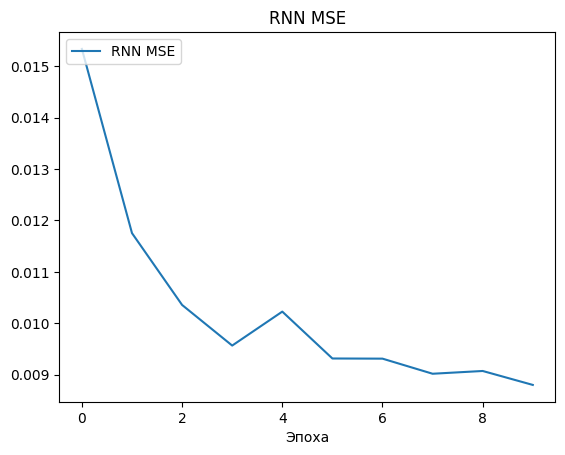

In [39]:
Plot.plot_history_trend(history=rnn_model.history, metric='RNN MSE') 

### Метрики

In [40]:
Metric.print_regression_metrics(y_true=y_test, y_pred=rnn_y_pred)

                
MSE   541.282010
RMSE   23.265468
R^2     0.433514


### График

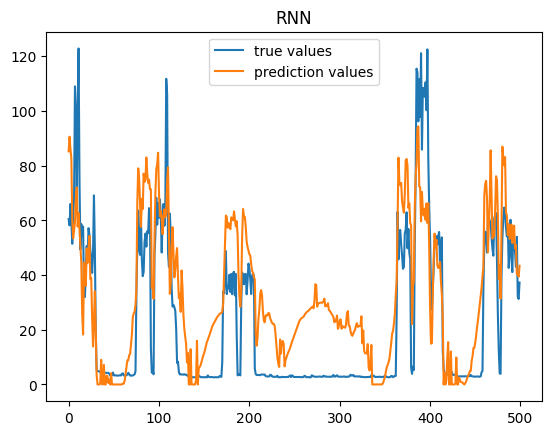

In [41]:
plot(rnn_y_pred, y_test, 'RNN')

## GRU

### История обучения

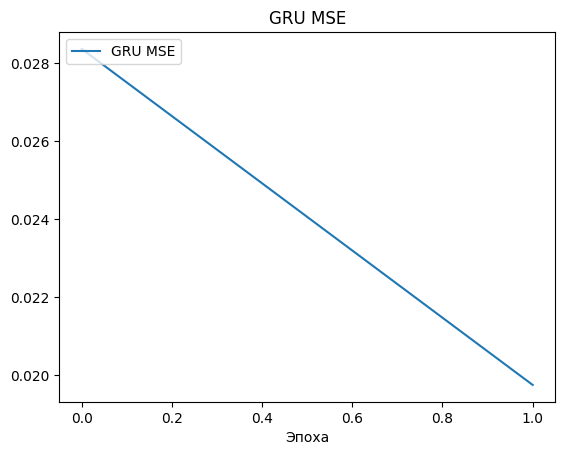

In [52]:
Plot.plot_history_trend(history=gru_model.history, metric='GRU MSE') 

### Метрики

In [54]:
Metric.print_regression_metrics(y_true=y_test, y_pred=gru_y_pred)

                
MSE   371.262692
RMSE   19.268178
R^2     0.611450


### График

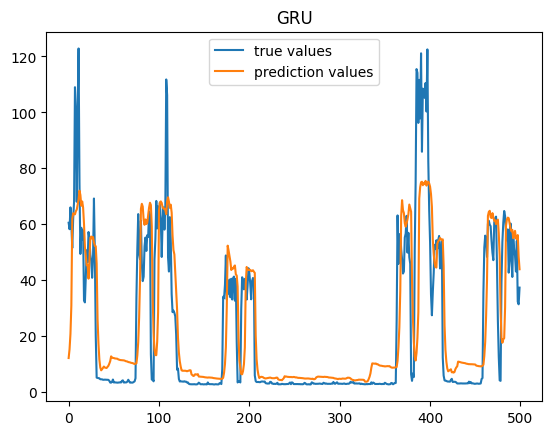

In [53]:
plot(gru_y_pred, y_test, 'GRU')

## LSTM

### История обучения

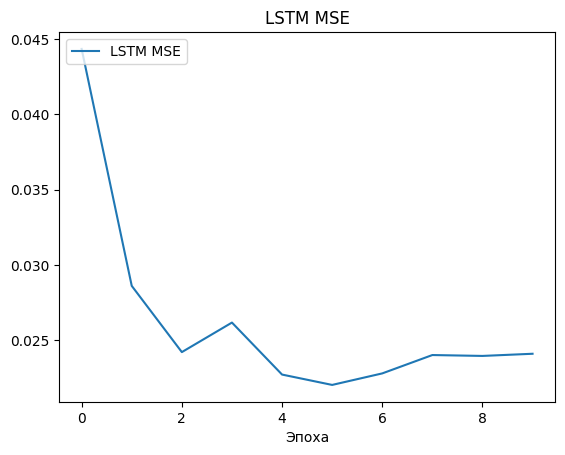

In [45]:
Plot.plot_history_trend(history=lstm_model.history, metric='LSTM MSE') 

### Метрики

In [46]:
Metric.print_regression_metrics(y_true=y_test, y_pred=lstm_y_pred)

                
MSE   483.203748
RMSE   21.981896
R^2     0.494296


### График

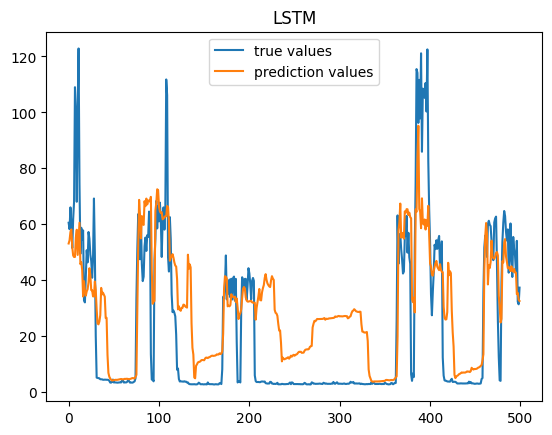

In [47]:
plot(lstm_y_pred, y_test, 'LSTM')